# Generalized Lasso Problem

In this project, we study the generalized lasso problem, and more specifically, the fused lasso problem and implement efficient algorithms for achieving an optimal solution.

The generalized lasso problem is defined in <cite data-cite="Tibs16">(Arnold et. al., 2016)</cite> as:

$$\min_{\beta} f(\beta) + \lambda ||D \beta ||_1 $$

where the objective $ f\left(\beta\right) = \frac{1}{2}||y - \beta||_2^2$ is strongly convex and smooth, $y \in \mathbf{R}^n$ is the input, $D \in \mathbf{R}^{m \times n}$ is a matrix which penalizes large changes with respect to the temporal or spatial structure forcing the coefficients to vary smoothly and $\lambda \ge 0$  is a regularization parameter. When $D = I$ the problem can be interpreted as the usual lasso problem.

We are going to specifically look at the fused lasso variant introduced in <cite data-cite="Tibs05">(Tibshirani et. al., 2005)</cite>. The fused lasso problem is a special case of the generalized lasso, defined as:

$$ ||D\beta||_1 = \sum ^{n-1} _{i = 1} |\beta_i - \beta_{i+1}| $$

for the 1D case. It is evident that this formulation generates sparsity not in the solution (like the usual lasso), but in the adjacent differences, i.e., it encourages adjacent members of the solution vector to be equal to each other. 

The fused lasso can be used for total variation denoising in 1D. Additionally, the fused lasso can be defined for total variation denoising over a graph, $G = (V, E)$, and is defined as:

$$ ||D\beta||_1 = \sum _{(i,j) \in E} |\beta_i - \beta_{j}| $$

which encourages the solution to have equal components across any $(i,j) \in E$. This can be especially useful for denoising images which can be represented as a 2D grid graph.

## 1-D Case (Total Variation Denoising and Linear Trend Filtering)

The first part of the project covers the simple 1-D (adjacency in only one dimension) case of the fused lasso, also called the total variation denoising in 1D. We have chosen the loss function to be the gaussian loss function, 

$$ f(\beta) = \frac{1}{2}\sum ^{n} _{i = 1} (y_i - \beta_{i})^2 $$

where $y_i$ are the points given in the data set. The matrix $D$ for the fused lasso problem can be defined as:

$$ D = \begin{bmatrix}
-1 & 1 & 0 & \cdots & 0 & 0 \\
0 & -1 & 1 & \cdots & 0 & 0 \\
\vdots \\
0 & 0 & 0 & \cdots & -1 & 1
\end{bmatrix}$$

so that $ ||D\beta||_1 = \sum _{(i,j) \in E} |\beta_i - \beta_{j}| $. This penalty function, as mentioned earlier, generates sparsity in adjacent differences.

Similarly, higher order fits are also possible. For example, a piecewise linear solution for $\beta$ is generated if the matrix $D$ is defined as:

$$ D = \begin{bmatrix}
1 & -2 & 1 & \cdots & 0 & 0 \\
0 & 1 & -2 & \cdots & 0 & 0 \\
\vdots \\
0 & 0 & 0 & \cdots & -2 & 1
\end{bmatrix}$$

#### Primal Subgradient Method

Subgradient algorithm can be used for the primal problem. We compute the subgradient of the cost function with respect to $\beta$ and set it to zero. The subgradient of the cost function is given as:

$$ g = \nabla f(\beta) + \lambda D^T \phi$$

where $\phi \in \partial || D \beta|| _1$. This can be expanded and written as:

$$ g = \beta - y + \lambda D^T \cdot sign(D\beta)$$

where $sign(D\beta)_i = 0$ when $(D\beta)_i = 0$. This approach works for any general $D$, and can be used for both the TV denoising and Trend Filtering cases in 1D, as well as the 2D graph case.

In [1]:
# Importing packages
import numpy as np
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse import linalg as spla
from time import time

In [2]:
# Generate 1D data with 4 different regimes. Each regime has a mean and variance.
def data(size):
    y = np.zeros((size,1))
    y[0:size/5] = 20*rn.random((size/5,1)) + 50
    y[size/5:3*size/5] = 15*rn.random((2*size/5,1)) + 30
    y[3*size/5:4*size/5] = 20*rn.random((size/5,1)) + 60
    y[4*size/5:size] = 10*rn.random((size/5,1)) + 90
    return y

# Penalty Matrix for TV Denoising
def denoisingMat(size):
    zeros = np.zeros([size-1, 1]); I = np.eye(size-1)
    add = np.hstack((zeros,I))
    sub = np.hstack((-I,zeros))
    D = add + sub
    return D

# Penalty Matrix for Linear Trend Filtering
def trendFilteringLinearMat(size):
    zeros1 = np.zeros([size-2, 1]); zeros2 = np.zeros([size-2, 2])
    I = np.eye(size-2)
    
    add1  = np.hstack((zeros2,I))
    sub   = np.hstack((zeros1, np.hstack((-2*I,zeros1))))
    add2  = np.hstack((I,zeros2))
    D = add1 + sub + add2
    return D

In [3]:
# Generalized Lasso Penalty
def costFunc(y, beta, D, lam):
    fVal = 0.5*la.norm(y - beta)**2 + lam*la.norm(np.dot(D,beta),ord = 1)
    return fVal

# Subgradient Descent for Lasso with diminishing step size
def subgradient(y, beta, D, t, lam, c=1e-1):
    step_size = c/(np.sqrt(t+1))
    obj_grad  = beta - y
    penalty_subgrad = lam*np.dot(D.T,np.sign(np.dot(D,beta)))
    delF = obj_grad + penalty_subgrad 
    beta = beta - step_size*delF
    return beta

# Choose the data set size
size = 1000
y = data(size)

# Descent function for primal subgradient method
def descent(update, probType, y, reg, T=int(1e3)):
    size = y.shape[0]
    D = probType(size)
    beta = np.zeros((size,1))
    error = []
    l1 = []
    timeIter = []
    startTime = time()
    for t in xrange(T):
        beta = update(y, beta, D, t, reg)
        # record error and l1 norm
        if (t % 1 == 0) or (t == T - 1):
            error.append(la.norm(beta - y))
            l1.append(np.sum(np.abs(np.dot(D,beta))))
            timeIter.append(time()-startTime)
            assert not np.isnan(error[-1])

    return beta, error, l1, timeIter

In [4]:
# Solving for different values of regularization parameter
beta_sg10, error_sg10, l1_sg10, timeIter_sg10 = descent(subgradient, denoisingMat, y, reg=10)
beta_sg5, error_sg5, l1_sg5, timeIter_sg5 = descent(subgradient, denoisingMat, y, reg=5)
beta_sg20, error_sg20, l1_sg20, timeIter_sg20 = descent(subgradient, denoisingMat, y, reg=20)

beta_sg10LT, error_sg10LT, l1_sg10LT, timeIter_sg10LT = descent(subgradient, trendFilteringLinearMat, y, reg=10)
beta_sg5LT, error_sg5LT, l1_sg5LT, timeIter_sg5LT = descent(subgradient, trendFilteringLinearMat, y, reg=5)
beta_sg20LT, error_sg20LT, l1_sg20LT, timeIter_sg20LT = descent(subgradient, trendFilteringLinearMat, y, reg=20)

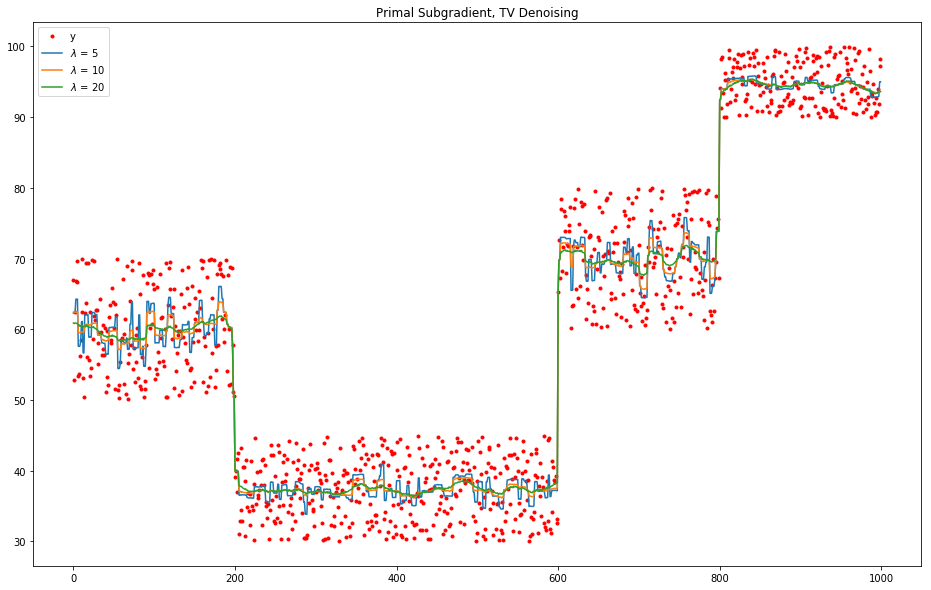

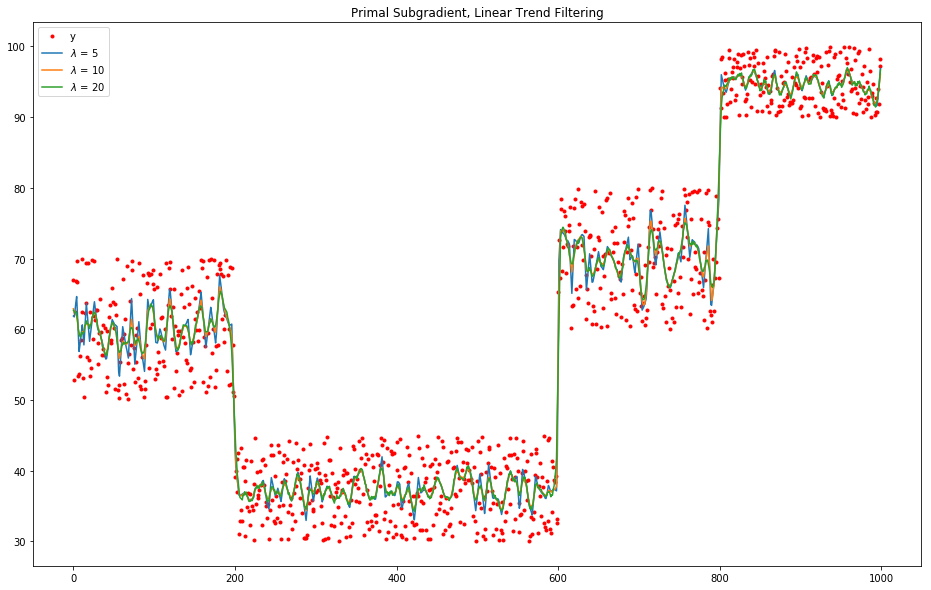

In [6]:
# Plotting
plt.clf()
plt.figure(figsize=(35,10))
plt.subplot(1, 2, 1)
plt.plot(y, 'r.',label='y')
plt.plot(beta_sg5,label='$\lambda$ = 5')
plt.plot(beta_sg10,label='$\lambda$ = 10')
plt.plot(beta_sg20,label='$\lambda$ = 20')
plt.title('Primal Subgradient, TV Denoising')
plt.legend()
plt.show()

plt.figure(figsize=(35,10))
plt.subplot(1, 2, 2)
plt.plot(y, 'r.',label='y')
plt.plot(beta_sg5LT,label='$\lambda$ = 5')
plt.plot(beta_sg10LT,label='$\lambda$ = 10')
plt.plot(beta_sg20LT,label='$\lambda$ = 20')
plt.title('Primal Subgradient, Linear Trend Filtering')
plt.legend()
plt.show()

### Dual Proximal Gradient Method

The dual of the problem can be derived <cite data-cite="Tibs11">(Tibshirani et. al., 2011)</cite> by rewriting the problem as:

$$\min_{\beta, z} \frac{1}{2}||y - \beta||_2^2 + \lambda ||z ||_1, z = D\beta $$

Therefore, writing the Lagrangian, 

$$\mathcal{L}(\beta, z, u) = \frac{1}{2}||y - \beta||_2^2 + \lambda ||z ||_1 + u^T(D\beta - z)$$

and minimizing over $\beta, z$, we can derive the dual problem. Since the minimization over $\beta, z$ can be separated out, we can write the Lagrangian dual as:

$$ \min_{\beta} \left( \frac{1}{2}||y - \beta||_2^2 + u^TD\beta \right) = -\frac{1}{2}||y - D^Tu||_2^2 $$

and 

$$ \min_{z} \left(\lambda ||z||_1 - u^Tz \right) = \begin{cases} 0 & \text{if } ||u||_{\infty} \leq \lambda \\ -\infty & \text{otherwise} \end{cases} $$

Thus, the dual problem can be written as:

$$ \min_{u} = \frac{1}{2}||y - D^Tu||_2^2 \texttt{ subject to }  ||u||_{\infty} \leq \lambda $$ 

The primal problem is always strictly convex and has a unique solution, and is strictly feasible since it has no inequality constraints, thus strong duality holds. Therefore, the primal solution can be derived from the dual solution. This relationship can be derived by taking the partial derivative of the Lagrangian with respect to $\beta$ as follows:

$$ \frac{\partial \mathcal{L}}{\partial \beta} = 0 \implies \beta = y - D^Tu$$

The proximal descent algortihm can now be applied to the dual problem, since the prox operator on $u$ is just

$$ prox_c(u) = \arg\min_{z} \frac{1}{2c}||u - z||_2^2 \texttt{ subject to }  ||u||_{\infty} \leq \lambda$$

which is the projection onto the box $[-\lambda,\lambda]^m$ where $u \in \mathbf{R}^m$. Since this projection can be calculated easily, the dual proximal gradient method is fast and much cheaper than the proximal gradient algorithm on the primal problem.

In [7]:
def gradientDualProx(y, u, D, lam, c=1e-1):
    delFStar = -np.dot(D,(y - np.dot(D.T,u)))
    u = u - c*(delFStar)
    u[u > lam] = lam
    u[u < -lam] = -lam
    return u

def descentDualProx(update, probType, y, reg, T=int(1e3)):
    size = y.shape[0]
    D = probType(size)
    beta = np.zeros((size,1))
    u = np.zeros((D.shape[0],1))
    
    error = []
    l1 = []
    timeIter = []
    startTime = time()
    for t in xrange(T):
        u = update(y, u, D, reg)
        # record error and l1 norm
        if (t % 1 == 0) or (t == T - 1):
            beta = y - np.dot(D.T,u)
            error.append(la.norm(beta - y))
            l1.append(np.sum(np.abs(np.dot(D,beta))))
            timeIter.append(time()-startTime)
            assert not np.isnan(error[-1])

    return beta, error, l1, timeIter

In [8]:
beta_dpg5, error_dpg5, l1_dpg5, timeIter_dpg5 = descentDualProx(gradientDualProx, denoisingMat, y, reg=5)
beta_dpg10, error_dpg10, l1_dpg10, timeIter_dpg10 = descentDualProx(gradientDualProx, denoisingMat, y, reg=10)
beta_dpg20, error_dpg20, l1_dpg20, timeIter_dpg20 = descentDualProx(gradientDualProx, denoisingMat, y, reg=20)

beta_dpg5LT, error_dpg5LT, l1_dpg5LT, timeIter_dpg5LT = descentDualProx(gradientDualProx, trendFilteringLinearMat, y, reg=5)
beta_dpg10LT, error_dpg10LT, l1_dpg10LT, timeIter_dpg10LT = descentDualProx(gradientDualProx, trendFilteringLinearMat, y, reg=10)
beta_dpg20LT, error_dpg20LT, l1_dpg20LT, timeIter_dpg20LT = descentDualProx(gradientDualProx, trendFilteringLinearMat, y, reg=20)

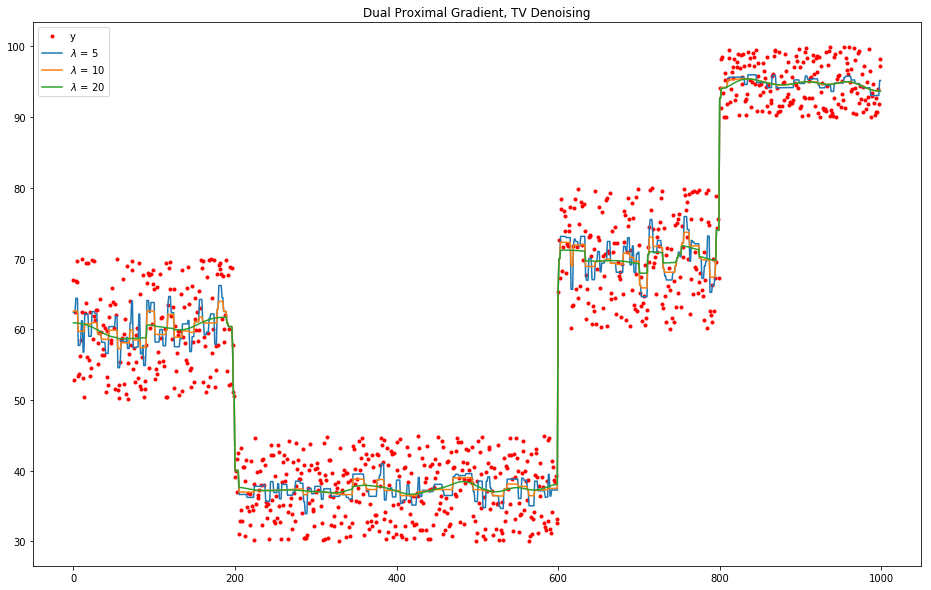

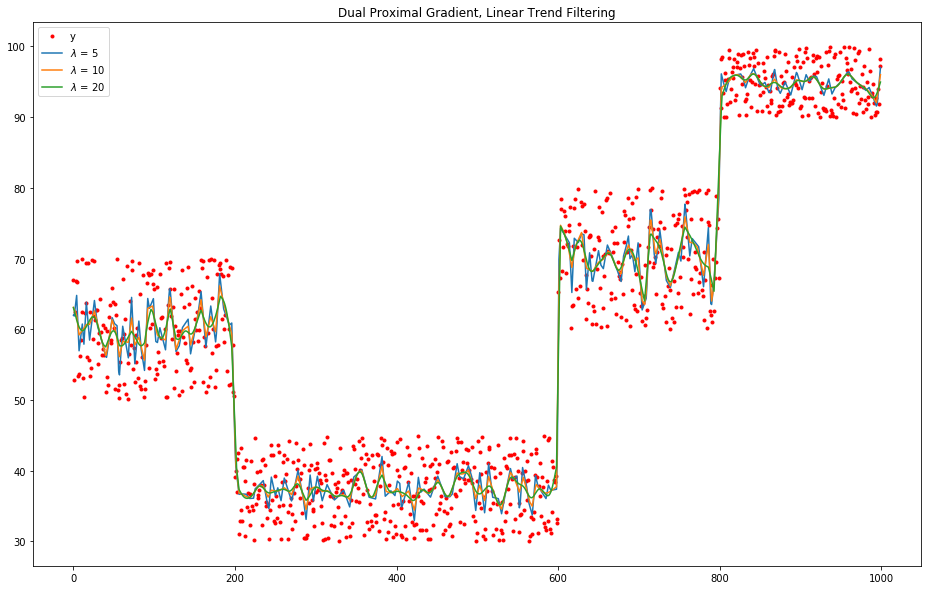

In [9]:
plt.clf()
plt.figure(figsize=(35,10))
plt.subplot(1, 2, 1)
plt.plot(y, 'r.',label='y')
plt.plot(beta_dpg5,label='$\lambda$ = 5')
plt.plot(beta_dpg10,label='$\lambda$ = 10')
plt.plot(beta_dpg20,label='$\lambda$ = 20')
plt.title('Dual Proximal Gradient, TV Denoising')
plt.legend()
plt.show()

plt.figure(figsize=(35,10))
plt.subplot(1, 2, 2)
plt.plot(y, 'r.',label='y')
plt.plot(beta_dpg5LT,label='$\lambda$ = 5')
plt.plot(beta_dpg10LT,label='$\lambda$ = 10')
plt.plot(beta_dpg20LT,label='$\lambda$ = 20')
plt.title('Dual Proximal Gradient, Linear Trend Filtering')
plt.legend()
plt.show()

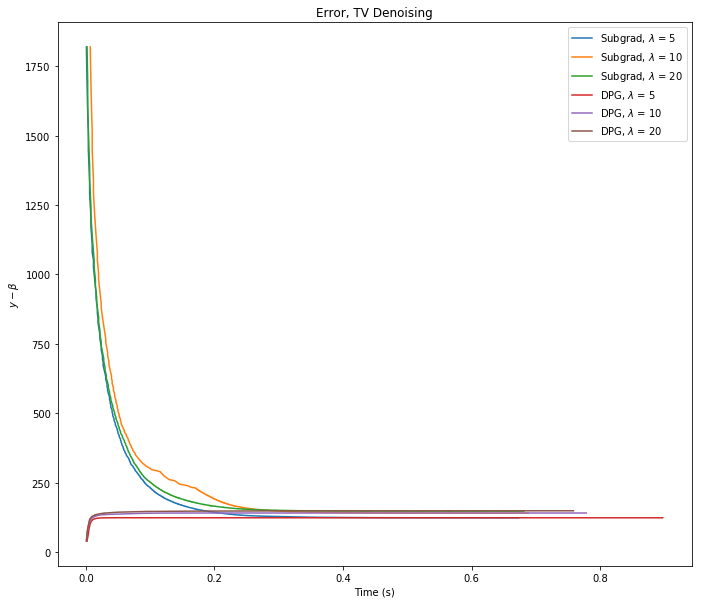

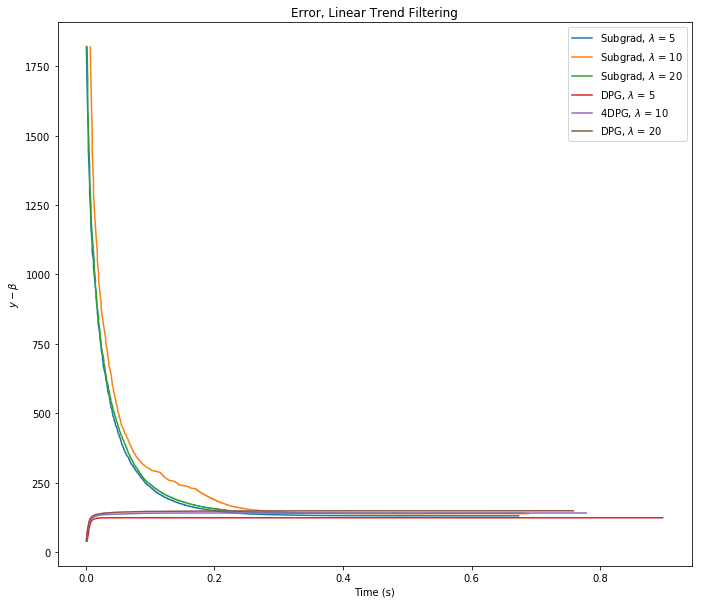

In [10]:
# Error Plotting
plt.clf()
plt.figure(figsize=(25,10))
plt.subplot(1, 2, 1)
plt.plot(timeIter_sg5, error_sg5,label='Subgrad, $\lambda$ = 5')
plt.plot(timeIter_sg10, error_sg10,label='Subgrad, $\lambda$ = 10')
plt.plot(timeIter_sg20, error_sg20,label='Subgrad, $\lambda$ = 20')
plt.plot(timeIter_dpg5, error_dpg5,label='DPG, $\lambda$ = 5')
plt.plot(timeIter_dpg10, error_dpg10,label='DPG, $\lambda$ = 10')
plt.plot(timeIter_dpg20, error_dpg20,label='DPG, $\lambda$ = 20')
plt.title('Error, TV Denoising')
plt.xlabel('Time (s)')
plt.ylabel('$y - \\beta$')
plt.legend()
plt.show()

plt.figure(figsize=(25,10))
plt.subplot(1, 2, 2)
plt.plot(timeIter_sg5, error_sg5LT,label='Subgrad, $\lambda$ = 5')
plt.plot(timeIter_sg10, error_sg10LT,label='Subgrad, $\lambda$ = 10')
plt.plot(timeIter_sg20, error_sg20LT,label='Subgrad, $\lambda$ = 20')
plt.plot(timeIter_dpg5, error_dpg5,label='DPG, $\lambda$ = 5')
plt.plot(timeIter_dpg10, error_dpg10,label='4DPG, $\lambda$ = 10')
plt.plot(timeIter_dpg20, error_dpg20,label='DPG, $\lambda$ = 20')
plt.title('Error, Linear Trend Filtering')
plt.xlabel('Time (s)')
plt.ylabel('$y - \\beta$')
plt.legend()
plt.show()

The dual proximal gradient method converges much faster than the primal subgradient method.

### Fast Dual Path Algorithm for 1D TV Denoising

<cite data-cite="Tibs11">(Tibshirani et. al., 2011)</cite> present an algorithm for solving the dual problem using a solution path approach. For both the 1D TV denoising case, the penalty matrix $D$ has more columns than rows, and therefore, the dual problem has a unique solution. Thus, to generate the solution path, we first present the boundary lemma <cite data-cite="Friedman11">(Friedman et. al., 2007)</cite>. 

The boundary lemma states that for the 1D case, where the solution to the dual problem is unique, for any coordinate $i$, the solution $u_{\lambda}$ of the dual problem satisfies 

$$ u_{\lambda _0,i} = \pm\lambda _0 \implies u_{\lambda,i} = \pm\lambda \texttt{ } \forall \texttt{ } 0 \leq \lambda \leq \lambda _0$$

This means that if a coordinate of the dual solution $u$ is on the boundary of the bounding box for some value of the regularization parameter $\lambda$, it will remain on the boundary as the value of $\lambda$ decreases. Thus, the solution path is generated starting from $\lambda = \infty$, and decreased to $\lambda = 0$, such that if a coordinate hits the boundary, it will stay on the boundary for the rest of the solution path. Thus, as its value is known at each smaller $\lambda$, that particular coordinate can be eliminated from future computations. 

The algorithm can then be presented as:

- Start with $\lambda = \infty$, $B, s = \emptyset$, where $B$ contains the coordinates currently on the bounday, $s$ contains their signs.
- Compute $\hat{u}$, the least squares solution of the unregularized dual problem, $$\min_{u} = \frac{1}{2}||y - D^Tu||_2^2$$ Choose the first hitting time ($\lambda_1$) and coordinate ($i_1$) as the maximum absolute value of any coordinate in $\hat{u}$, and the coordinate corresponding to the maximum value respectively. Set $B = {i_1}$ and $s = sign(\hat{u}_{i_1})$. 
- For k = 1,...,n-2:
    1. For $\lambda_k$, compute the solution to the least squares problem $$\min_{u_{-B}} = \frac{1}{2}||y - \lambda (D_{B})^Ts - (D_{-B})^Tu_{-B}||_2^2$$ where $u_{-B}$ are the coordinates of $u$ not present in the boundary set $B$, $D_{B}$ represents the rows of $D$ whose coordinates are in $B$, and $D_{-B}$ represents the rows of $D$ whose coordinates are not in $B$. This is basically solving for the interior coordinates at each point, i.e., the points which are not on the boundary. This problem can be solved by finding the least squares solution for the two problems: $$ \min_{a \in \mathbf{R}^{m-|B|}} = ||y - (D_{-B})^Ta||_2^2$$ and $$ \min_{b \in \mathbf{R}^{m-|B|}} = ||(D_{B})^Ts - (D_{-B})^Tb||_2^2$$ This is because the solution to the least squares problem mentioned above can be written as: $$\hat{u}_{\lambda_k, -B} = (D_{-B}(D_{-B})^T)^{-1}D_{-B}(y - \lambda_k (D_{B})^Ts)$$ which is equal to $a - \lambda_k b$.
    2. The 'hitting times' of each interior coordinate can be calculated as: $$t_i = \frac{a_i}{b_i \pm 1}$$ where only one of $\pm 1$ is in the range $[0,\lambda_k]$. Then, $$\lambda_{k+1} = \max_i t_i$$
    3. Add the hitting coordinate to $B$ and its sign to $s$.
    
The solution for $\lambda \in [\lambda_{k+1}, \lambda_k]$ can then be written as: $$\hat{u} _{-B_k} = a_k - \lambda b_k$$ and $$\hat{u}_{B_k} = \lambda s_k $$

This can then be used to solve for the primal solution as shown above. The results for the TV denoising case in 1D is shown below for the same data set as used in the primal subgradient and the dual proximal gradient algorithms.

In [11]:
def descentDualPath(y, reg):
    size = y.shape[0]
    D = denoisingMat(size)
    totalSet = np.arange(D.shape[0])
    x = spla.lsqr(D.T,y.flatten())
    u = x[0]
    uVec = np.expand_dims(u,1)
    beta = y - np.dot(D.T,uVec)
    lam = np.max(np.abs(u))
    iHit = np.argmax(np.abs(u))
    B = np.array([iHit])
    sgn = np.sign(u[iHit])
    s = np.array([sgn])
    counter = 0
    
    while lam > 0:
        counter = counter + 1
        
        BMinus = setExclusion(B, totalSet)
        if BMinus.size == 0:
            break
        
        DBMinus = D[BMinus,:]
        DB = D[B,:]
        x1 = spla.lsqr(DBMinus.T,y.flatten())
        x2 = spla.lsqr(DBMinus.T, np.dot(DB.T,np.expand_dims(s,1)))
        a = x1[0]
        b = x2[0]
        tHit, iHit, sHit = hittingCoordinate(a, b, BMinus, lam)

        lam = tHit
        u[BMinus] = a - lam*b
        u[B] = lam*s
        BOld = B.copy()
        B = np.append(B,iHit)
#         sgn = np.sign(u[iHit])
        sOld = s.copy()
#         s = np.append(s, sgn)
        s = np.append(s, sHit)
        
        if lam < reg:
            u[BMinus] = a - reg*b
            u[BOld] = reg*sOld
            break
            
    u = np.expand_dims(u,1)
    beta = y - np.dot(D.T,u)   
    return beta    
        
def setExclusion(B, totalSet):
    mask = np.array([(i in B) for i in xrange(len(totalSet))])
    BMinus = totalSet[~mask]
    return BMinus

def hittingCoordinate(a, b, BMinus, lam):
#     t = np.maximum((a/(b+1)),((a/(b-1))))
#     t[t>lam] = np.minimum((a[t>lam]/(b[t>lam]+1)),((a[t>lam]/(b[t>lam]-1))))
    t = a/(b + np.sign(a))
    t[t > lam + 1e-06] = 0
    t[t > lam] = lam
    t = np.nan_to_num(t)
    if t.size > 0:
        i = np.argmax(t)
        s = np.sign(a)[i]
        i = BMinus[i]
        t = np.max(t)
    else:
        t = 0
        i = 0
        s = 1
    return t, i, s

In [12]:
beta_dp = descentDualPath(y, reg=20)

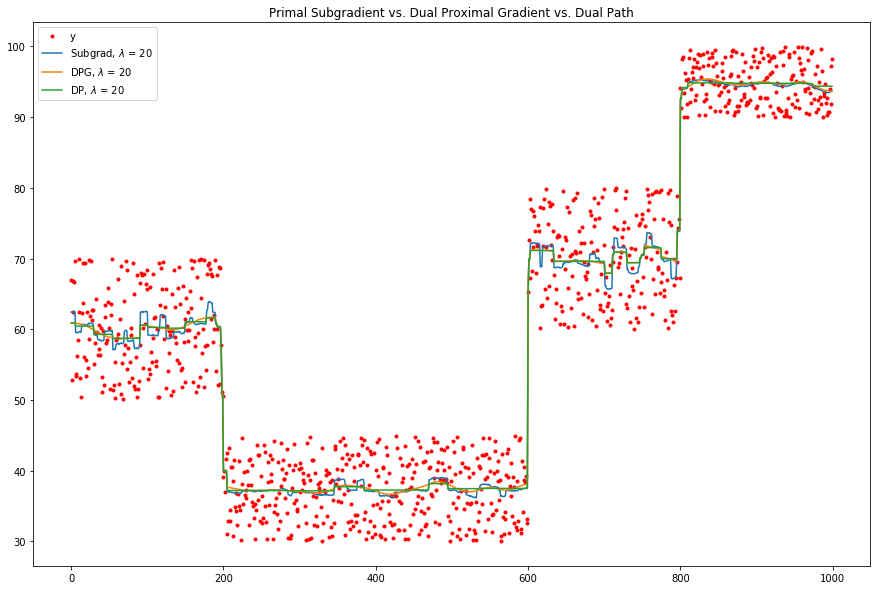

In [13]:
plt.clf()
plt.figure(figsize=(15,10))
plt.plot(y, 'r.',label='y')
plt.plot(beta_sg10,label='Subgrad, $\lambda$ = 20')
plt.plot(beta_dpg20,label='DPG, $\lambda$ = 20')
plt.plot(beta_dp,label='DP, $\lambda$ = 20')
plt.title('Primal Subgradient vs. Dual Proximal Gradient vs. Dual Path')
plt.legend()
plt.show()

## Graph (Total Variation Denoising)

For TV denoising in the graph (2D) case, we choose greyscale pictures corrupted with noise as our data sets. A greyscale image can be represented as a 2D graph, with edges between adjacent pixels. For an image of size $r \times c$, the image vector $y \in \mathbf{R}^{rc}$ is generated. Thus, the penalty matrix $D$ can be written as follows: 

$$D = \begin{bmatrix}
D_1 \\ 
D_2
\end{bmatrix}$$

$$ D_{1,(i,j)}^{r(c-1) \times rc} = \begin{cases} -1 & \text{ if } i = j \\ 
                                                  1 & \text{ if } i+1 = j \\
                                                  0 & \text{ otherwise }\end{cases}$$
                                                  
and 

$$ D_{2,(i,j)}^{(r-1)c \times rc} = \begin{cases} 1 & \text{ if } i = j \\ 
                                                  -1 & \text{ if } i+c = j \\
                                                  0 & \text{ otherwise }\end{cases}$$
              
Once the penalty matrix is defined, the same approach is used as in the 1D TV denoising case for both the primal subgradient algorithm and the dual proximal gradient algorithm.

### Primal Subgradient Method

In [14]:
# Import image package
from PIL import Image

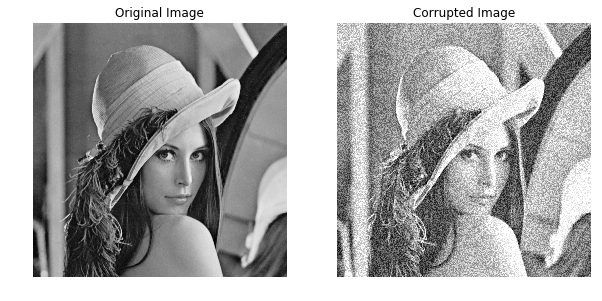

In [15]:
def loadImage(imageName, noise):
    # Convert to arrays.
    orig_img = Image.open(imageName)

    np.random.seed(1)
    Uorig = np.array(orig_img)
    row, col = Uorig.shape
    
    Ucorr = Uorig + noise*rn.random((row, col))
    Ucorr[Ucorr > 255] = 255
    Ucorr[Ucorr < 0] = 0
    
    corr_img = Image.fromarray(np.uint8(Ucorr))
    return Ucorr, corr_img, orig_img

Ucorr, corr_img, orig_img = loadImage("data/lena.png", 100)

%matplotlib inline
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
print ax
ax[0].imshow(np.asarray(orig_img),cmap='gray');
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_img),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

In [16]:
def denoisingMat2DGrid(size):
    add = np.eye(size)
    sub = -np.eye(size)
    D = np.concatenate((add,sub),axis = 1)
    return D

def denoisingMatGraph(row, col):
    D1 = np.zeros(((row)*(col-1),row*col))
    D2 = np.zeros(((row-1)*(col),row*col))
    DSegmentRow = denoisingMat(col)
    DSegmentCol = denoisingMat2DGrid(col)
    for i in range(row):
        startRow = i*(col-1)
        endRow = (i+1)*(col-1)
        startCol = i*(col)
        endCol = (i+1)*(col)
        D1[startRow:endRow,startCol:endCol] = DSegmentRow
    for i in range(row-1):
        startRow = i*(col)
        endRow = (i+1)*(col)
        startCol = i*(col)
        endCol = (i+2)*(col)
        D2[startRow:endRow,startCol:endCol] = DSegmentCol
    D = np.concatenate((D1, D2), axis = 0)
    return D

def denoisingMatGraphSparse(row,col):
    D1 = sp.csr_matrix(((row)*(col-1),row*col))
    D2 = sp.csr_matrix(((row-1)*(col),row*col))
    DSegmentRow = sp.csr_matrix(denoisingMat(col))
    DSegmentCol = sp.csr_matrix(denoisingMat2DGrid(col))
    for i in range(row):
        startRow = i*(col-1)
        endRow = (i+1)*(col-1)
        startCol = i*(col)
        endCol = (i+1)*(col)
        D1[startRow:endRow,startCol:endCol] = DSegmentRow
    for i in range(row-1):
        startRow = i*(col)
        endRow = (i+1)*(col)
        startCol = i*(col)
        endCol = (i+2)*(col)
        D2[startRow:endRow,startCol:endCol] = DSegmentCol
    D = sp.vstack([D1, D2])
    return D

def subgradientGraph(y, beta, D, t, lam, c=1e-1):
    betaSp = sp.csr_matrix(beta)
    ySp = sp.csr_matrix(y)
    delF1 = betaSp - ySp
    dotProd1 = D.dot(betaSp)
    dotProd1[dotProd1 > 0] = 1
    dotProd1[dotProd1 < 0] = -1
    delF2 = D.T.dot(dotProd1)*lam
    delF = delF1 + delF2
    betaSp = betaSp - c/(np.sqrt(t+1))*(delF)
    beta = betaSp.toarray()
    return beta

In [17]:
def descentGraph(update, Ucorr, reg, T=int(7e2)):
    row, col = Ucorr.shape
    y = np.reshape(Ucorr, (-1, 1))
    D = denoisingMatGraphSparse(row, col)
    beta = np.zeros((y.shape[0],1))
    error = []
    l1 = []
    timeIter = []
    startTime = time()
    for t in xrange(T):
        beta = update(y, beta, D, t, reg)
        betaSp = sp.csr_matrix(beta)
        # record error and l1 norm
        if (t % 1 == 0) or (t == T - 1):
            error.append(la.norm(beta - y))
            timeIter.append(time() - startTime)
            l1.append(np.sum(np.abs(D.dot(betaSp).toarray())))
            assert not np.isnan(error[-1])
    
    beta = np.reshape(beta, (row, col))
    return beta, error, l1, timeIter

In [18]:
beta_sg_graph, error_sg_graph, l1_sg_graph, timeIter_sg_graph = descentGraph(subgradientGraph, Ucorr, reg=20)

C:\ProgramData\Anaconda2\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


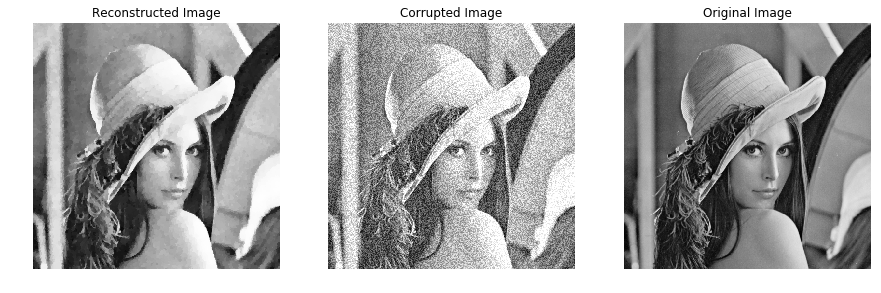

In [19]:
reconstruct_img = Image.fromarray(np.uint8(beta_sg_graph))

%matplotlib inline
fig, ax = plt.subplots(1, 3,figsize=(15, 10))
print ax
ax[0].imshow(np.asarray(reconstruct_img),cmap='gray');
ax[0].set_title("Reconstructed Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_img),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(np.asarray(orig_img),cmap='gray');
ax[2].set_title("Original Image")
ax[2].axis('off');

### Dual Proximal Gradient Method

In [20]:
def gradientDualProxSparse(y, u, D, lam, c=1e-1):
    uSp = sp.csr_matrix(u)
    ySp = sp.csr_matrix(y)
    dotProd1 = D.T.dot(uSp)
    sum1 = ySp - dotProd1
    delFStar = -D.dot(sum1)
    uSp = uSp - c*(delFStar)
    uSp[uSp > lam] = lam
    uSp[uSp < -lam] = -lam
    u = uSp.toarray()
    return u

In [21]:
def descentDualProxGraph(update, Ucorr, reg, T=int(7e2)):
    row, col = Ucorr.shape
    y = np.reshape(Ucorr, (-1, 1))
    D = denoisingMatGraphSparse(row, col)
    u = np.zeros((D.shape[0],1))
    
    error = []
    l1 = []
    timeIter = []
    startTime = time()
    for t in xrange(T):
        u = update(y, u, D, reg)
        # record error and l1 norm
        if (t % 1 == 0) or (t == T - 1):
            uSp = sp.csr_matrix(u)
            ySp = sp.csr_matrix(y)
            vSp = -D.T.dot(uSp)
            v = vSp.toarray()
            betaSp = ySp + vSp 
            error.append(la.norm(betaSp.toarray() - y))
            timeIter.append(time() - startTime)
            l1.append(np.sum(np.abs(D.dot(betaSp).toarray())))
            assert not np.isnan(error[-1])
    
    beta = betaSp.toarray()
    beta = np.reshape(beta, (row, col))
    return beta, error, l1, timeIter

In [22]:
beta_dpg_graph, error_dpg_graph, l1_dpg_graph, timeIter_dpg_graph = descentDualProxGraph(gradientDualProxSparse, Ucorr, reg=20)

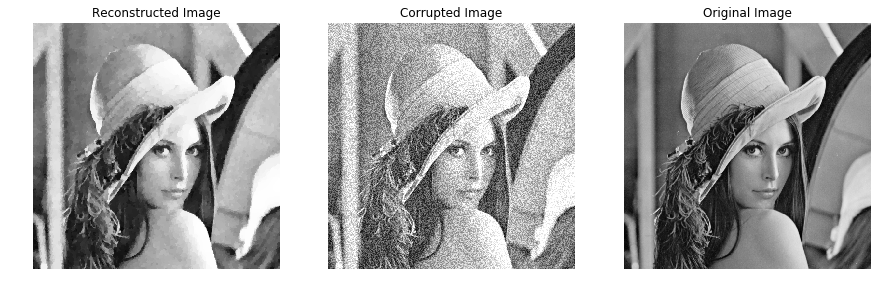

In [23]:
reconstruct_img_dpg = Image.fromarray(np.uint8(beta_dpg_graph))

%matplotlib inline
fig, ax = plt.subplots(1, 3,figsize=(15, 10))
print ax
ax[0].imshow(np.asarray(reconstruct_img_dpg),cmap='gray');
ax[0].set_title("Reconstructed Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_img),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(np.asarray(orig_img),cmap='gray');
ax[2].set_title("Original Image")
ax[2].axis('off');

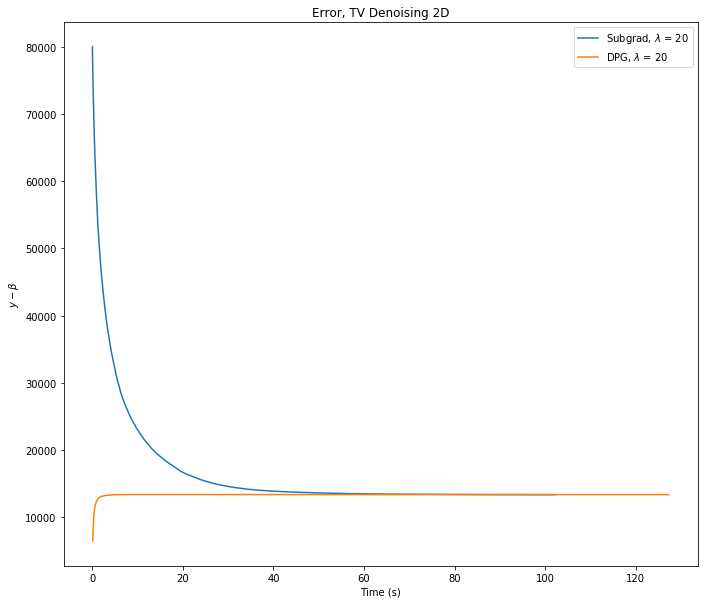

In [24]:
plt.clf()
plt.figure(figsize=(25,10))
plt.subplot(1, 2, 1)
plt.plot(timeIter_sg_graph, error_sg_graph,label='Subgrad, $\lambda$ = 20')
plt.plot(timeIter_dpg_graph, error_dpg_graph,label='DPG, $\lambda$ = 20')
plt.title('Error, TV Denoising 2D')
plt.xlabel('Time (s)')
plt.ylabel('$y - \\beta$')
plt.legend()
plt.show()

Again, the dual proximal gradient converges much faster than the primal subgradient method. The reconstructed images are quite close to the original images, with most of the noise removed.

### Fast Dual Path Algorithm

For the 2D graph case <cite data-cite="Tibs11">(Tibshirani et. al., 2011)</cite>, the boundary lemma defined earlier does not hold true any more. Therefore, coordinates on the boundary may also leave the boundary, and this needs to be checked as well. To check for leaving coordinates, in addition to the hitting times, we also compute the leaving times. Using the same notations as in the 1D case, the leaving times are calculated as:

$$c = s \cdot \left[D_B[I - (D_{-B})^T(D_{-B}(D_{-B})^T)^{+}D_{-B}]y\right] $$
$$d = s \cdot \left[D_B[I - (D_{-B})^T(D_{-B}(D_{-B})^T)^{+}D_{-B}] (D_{B})^Ts\right]$$
$$t_i^{(leave)} = \begin{cases} c_i/d_i & \text{ if } c < 0 \text{ and } d < 0 \\ 
                                0 & \text{ otherwise}\end{cases}$$

The next leaving time is chosen as:
$$ l_{k+1} = \max_i t_i^{(leave)}$$

If $h_{k+1}$ is the next hitting time, $\lambda _{k+1}$ is chosen as $\max \{h_{k+1},l_{k+1}\}$. If $h_{k+1} > l_{k+1}$, the hitting coordinate and its sign are added to $B$ and $s$ respectively, and if the opposite case holds, the leaving coordinate and its sign are removed from the respective sets.

We test the dual path algorithm on a smaller image with two distinct regions.

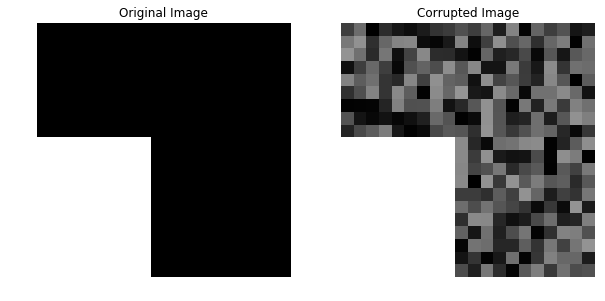

In [25]:
UcorrSmall, corr_imgSmall, orig_imgSmall = loadImage("data/testImage3.png", 150)

%matplotlib inline
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
print ax
ax[0].imshow(np.asarray(orig_imgSmall),cmap='gray');
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_imgSmall),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

In [26]:
beta_sg_graphSmall, error_sg_graphSmall, l1_sg_graphSmall, timeIter_sg_graphSmall = descentGraph(subgradientGraph, UcorrSmall, reg=10)
beta_dpg_graphSmall, error_dpg_graphSmall, l1_dpg_graphSmall, timeIter_dpg_graphSmall = descentDualProxGraph(gradientDualProxSparse, UcorrSmall, reg=10)

In [27]:
def descentDualPathGraph(Ucorr, reg):
    row, col = Ucorr.shape
    y = np.reshape(Ucorr, (-1, 1))
    D = denoisingMatGraphSparse(row, col)
    totalSet = np.arange(D.shape[0])
    x = spla.lsqr(D.T,y.flatten())
    u = x[0]
    uVec = np.expand_dims(u,1)
    beta = y - D.T.dot(uVec)
    lam = np.max(np.abs(u))
    iHit = np.argmax(np.abs(u))
    B = np.array([iHit])
    sgn = np.sign(u[iHit])
    s = np.array([sgn])
    counter = 0
    
    while lam > 0:
#         print '\n'
#         print 'counter= ', counter
        counter = counter + 1
        BMinus = setExclusion(B, totalSet)
        B = np.sort(B)
        if BMinus.size == 0:
            break
        DBMinus = D[BMinus,:]
        DB = D[B,:]
        x1 = spla.lsqr(DBMinus.T,y.flatten())
        x2 = spla.lsqr(DBMinus.T, DB.T.dot(np.expand_dims(s,1)))
        a = x1[0]
        b = x2[0]

        tHit, iHit, sHit = hittingCoordinateGraph(a, b, BMinus, lam)
        tLeave, iLeave = leavingCoordinate(a, b, DB, DBMinus, y, s, lam)
        
        if tHit>tLeave:
            lam = tHit
            u[BMinus] = a - lam*b
            u[B] = lam*s
            BOld = B.copy()
            B = np.append(B,iHit)
            sOld = s.copy()
            s = np.append(s, sHit)
            flag = 0
        else:
            lam = tLeave
            u[BMinus] = a - lam*b
            u[B] = lam*s
            BOld = B.copy()
            sOld = s.copy()
            leavingCoord = B[iLeave]
            B = np.delete(B,iLeave,0)
            s = np.delete(s,iLeave,0)
            flag = 1
#         print 'lam=', lam 
#         print 'B Shape=', B.shape
        if lam < reg:
            u[BMinus] = a - reg*b
            u[BOld] = reg*sOld
            break
    u = np.expand_dims(u,1)
    beta = y - D.T.dot(u)
    beta = np.reshape(beta, (row, col))
    return beta    

def setExclusion(B, totalSet):
    mask = np.array([(i in B) for i in xrange(len(totalSet))])
    BMinus = totalSet[~mask]
    return BMinus

def hittingCoordinateGraph(a, b, BMinus, lam):
    t = a/(b + np.sign(a))
    t[t > lam + 1e-06] = 0
    t[t > lam] = lam
    t = np.nan_to_num(t)
    if t.size > 0:
        i = np.argmax(t)
        iMax = BMinus[i]
        tMax = np.max(t)
        sMax = np.sign(a)[i]
    else:
        tMax = 0
        iMax = 0
        sMax = 1
    return tMax, iMax, sMax
                   
def leavingCoordinate(a, b, DB, DBMinus, y, s, lam):
    a = np.expand_dims(a,1)
    b = np.expand_dims(b,1)
    s = np.expand_dims(s,1)
    c = s*(DB.dot(y - DBMinus.T.dot(a)))
    c = c.flatten()
    d = s*(DB.dot(DB.T.dot(s) - DBMinus.T.dot(b)))
    d = d.flatten()
    
    t = c/d
    t[c>0] = 0
    t[t > lam + 1e-06] = 0
    t[t > lam] = lam
    t = np.nan_to_num(t)
    i = np.argmax(t)
    t = t[i]

    return t, i
  

In [28]:
beta_dp_graphSmall = descentDualPathGraph(UcorrSmall, reg=10)
beta_dp_graphSmall[beta_dp_graphSmall<0] = 0
beta_dp_graphSmall[beta_dp_graphSmall>255] = 255

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in divide


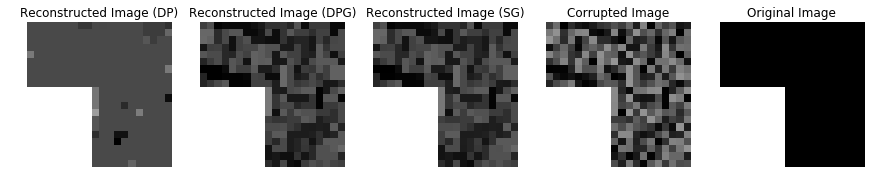

In [29]:
reconstruct_img_dpSmall = Image.fromarray(np.uint8(beta_dp_graphSmall))
reconstruct_img_dpgSmall = Image.fromarray(np.uint8(beta_dpg_graphSmall))
reconstruct_img_sgSmall = Image.fromarray(np.uint8(beta_sg_graphSmall))

%matplotlib inline
fig, ax = plt.subplots(1, 5,figsize=(15, 10))
print ax
ax[0].imshow(np.asarray(reconstruct_img_dpSmall),cmap='gray');
ax[0].set_title("Reconstructed Image (DP)")
ax[0].axis('off')
ax[1].imshow(np.asarray(reconstruct_img_dpgSmall),cmap='gray');
ax[1].set_title("Reconstructed Image (DPG)")
ax[1].axis('off')
ax[2].imshow(np.asarray(reconstruct_img_sgSmall),cmap='gray');
ax[2].set_title("Reconstructed Image (SG)")
ax[2].axis('off')
ax[3].imshow(np.asarray(corr_imgSmall),cmap='gray');
ax[3].set_title("Corrupted Image")
ax[3].axis('off');
ax[4].imshow(np.asarray(orig_imgSmall),cmap='gray');
ax[4].set_title("Original Image")
ax[4].axis('off');


In [444]:
%%bash
ipython nbconvert --to latex --template citations.tplx Project_SB.ipynb
pdflatex Project.tex
bibtex Project
pdflatex Project.tex
pdflatex Project.tex
pdflatex Project.tex

Couldn't find program: u'bash'


## References

<cite data-cite="Tibs16">(Arnold et. al., 2016)</cite> T. B. Arnold and R. J. Tibshirani, "Efficient Implementations of the Generalized Lasso Dual Path Algorithm", _Journal of Computational and Graphical Statistics_ 25(1) [2016], pp. 1-27.

<cite data-cite="Tibs05">(Tibshirani et. al., 2005)</cite> R. Tibshirani _et. al._, "Sparsity and smoothness via the fused lasso", _Journal of the Royal Statistical Society: Series B_ 67(1) [2005], pp. 91-108. 

<cite data-cite="Tibs11">(Tibshirani et. al., 2011)</cite> R.J. Tibshirani and J. Taylor, "The solution path of the generalized lasso", _Annals of Statistics_ 39(3) [2011], pp. 1335-1371.

<cite data-cite="Friedman11">(Friedman et. al., 2007)</cite>  J. Friedman _et. al._, "Pathwise coordinate optimization", _Annals of Applied Statistics_ 1(2) [2007], pp. 302–332.
